In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

az.style.use('arviz-whitegrid')
warnings.filterwarnings('ignore', module='seaborn')

In [2]:
# Set the random seed
np.random.seed(42)

# Linear Regression

## Linear Regression

Probabilistically, a **linear regression** model can be expressed as follows:

$$\mu = \alpha + X\beta$$
$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

where $X$ denotes the input feature, $Y$ denotes the target feature, and $\alpha$ and $\beta$ are respectively *intercept* and *slope* of the linear relationship.
So, the targets are assumed to be distributed as a Gaussian with mean $\alpha + \beta X$ and standard deviation $\epsilon$, which controls the amount of noise in our data.# Linear Regression

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$, we have to set prior distributions for them.
A common yet reasonable choice for such distributions are the Gaussian and the non-negative Gaussian distribution (also called Half-Gaussian).

Alternatively, a prior distribution on the amount of noise can be the non-negative Cauchy distribution (also called Half-Cauchy), which have longer tails hence permitting to explore a wider space when sampling from the posterior.

$$\alpha \sim \mathrm{Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathrm{Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathrm{Normal}(0,\sigma_\epsilon)| \quad\text{or}\quad \epsilon \sim |\mathrm{Cauchy}(0,\sigma_\epsilon)|$$

The usage of Gaussian priors for the weights $\alpha$ and $\beta$ means that we are _penalizing_ very large absolute values in favour of values near zero.

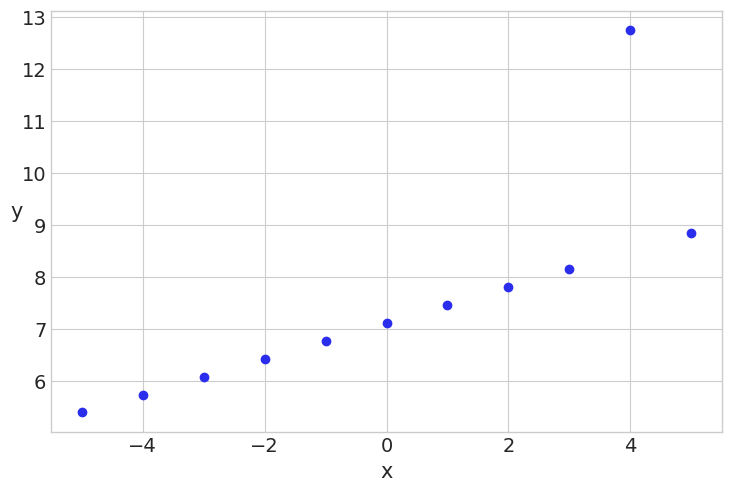

In [3]:
# Load one of the Anscombe quartet
data = pd.read_csv('data/anscombe.csv')
x = data[data.group == 'III']['x'].values
y = data[data.group == 'III']['y'].values
x -= x.mean()

# Plot the data
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

Using PyMC3 we can build a linear regression model with almost a _one-to-one_ correspondence with the formulas showed above.
Moreover, we can easily sample from the **posterior distribution**.
In other words, we obtain the parameters values that are _consistent_ with the underlying data, of course with different amount of _likelihood_.

In [4]:
# Build a PyMC3 linear regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0.0, sd=8.0)
    beta = pm.Normal('beta', mu=0.0, sd=8.0)
    eps = pm.HalfCauchy('eps', 5.0)
    y_pred = pm.Normal('y_pred', mu=alpha + x * beta, sd=eps, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 14 seconds.


Using Arviz we can plot both the posterior distributions of our parameters, the obtained traces given by the **Markov Chain Monte Carlo** (MCMC) procedure, and the related auto-correlogram.

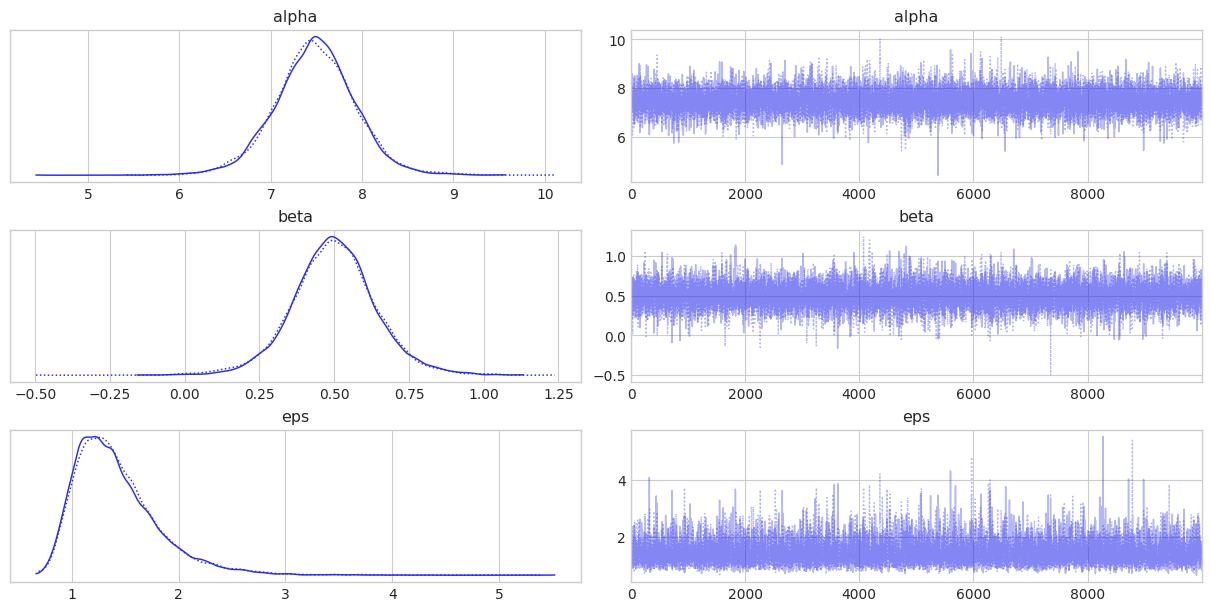

In [5]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps'])
plt.show()

[]

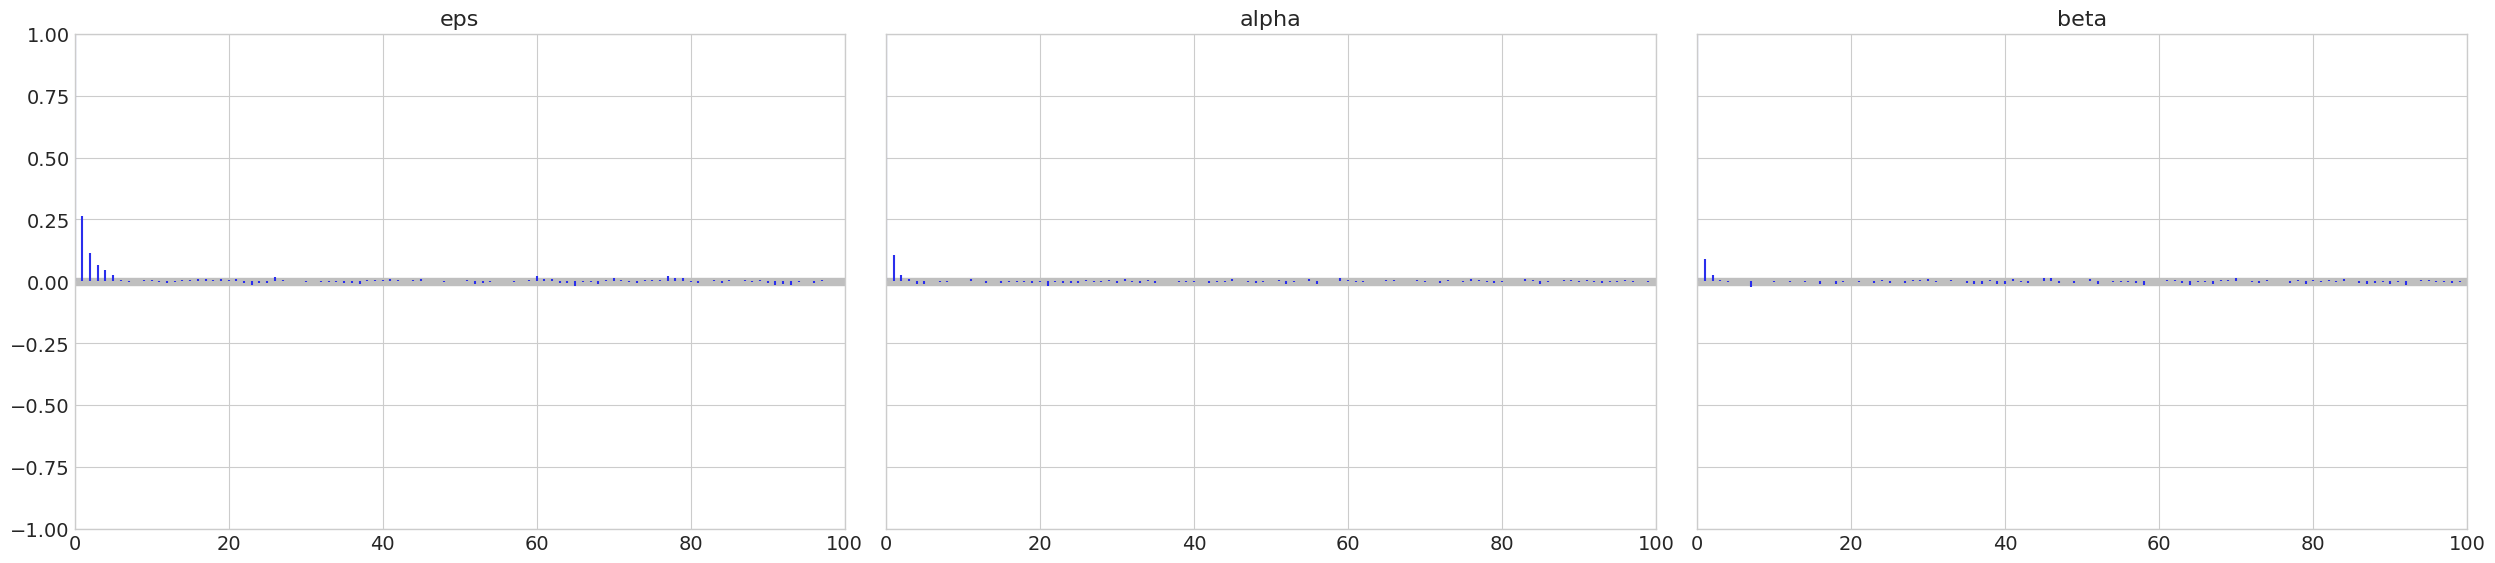

In [6]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

For graphical representation purposes, we can consider the _average_ of the sampled values for $\alpha$ and $\beta$ parameters.
Moreover, for each input data point we can sample from the _conditional_ probability distribution using PyMC3.
So, in other words we can plot the target samples in the **Highest Density Interval** (HDI). 

In [7]:
# Compute average values of sampled parameters
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

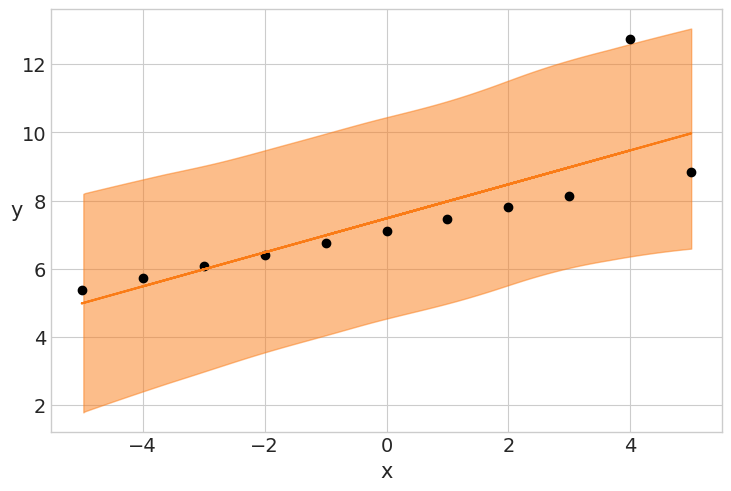

In [8]:
# Plot the HDI graph
az.plot_hdi(x, ppc['y_pred'])
plt.plot(x, y, 'o', c='k')
plt.plot(x, alpha_m + beta_m * x, c='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

## Robust Linear Regression

As noted previously, the presence of outliers in our data might make our Gaussian assumption fail.
In general a Student t-distribution is a way to effectively deal with outliers and get a more robust inference.
To do so, we must define another prior distribution over the _degrees of freedom_ of the Student t-distribution.
A common choice for this prior is given by a translated Exponential distribution.
The resulting robust linear regression model is defined below.

$$\alpha \sim \mathrm{Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathrm{Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathrm{Normal}(0,\sigma_\epsilon)|$$
$$\nu \sim 1 + \mathrm{Exponential}(\lambda)$$
$$y \sim \alpha + \beta X + \epsilon \cdot \mathcal{StudentT}(\nu)$$

In [9]:
# Build a PyMC3 linear (robust) regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0.0, sd=8.0)
    beta = pm.Normal('beta', mu=0.0, sd=8.0)
    eps = pm.HalfCauchy('eps', 5.0)
    nu = 1 + pm.Exponential('nu', 1.0 / 29.0)
    y_pred = pm.StudentT('y_pred', mu=alpha + x * beta, sd=eps, nu=nu, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000, target_accept=0.9,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, eps, beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


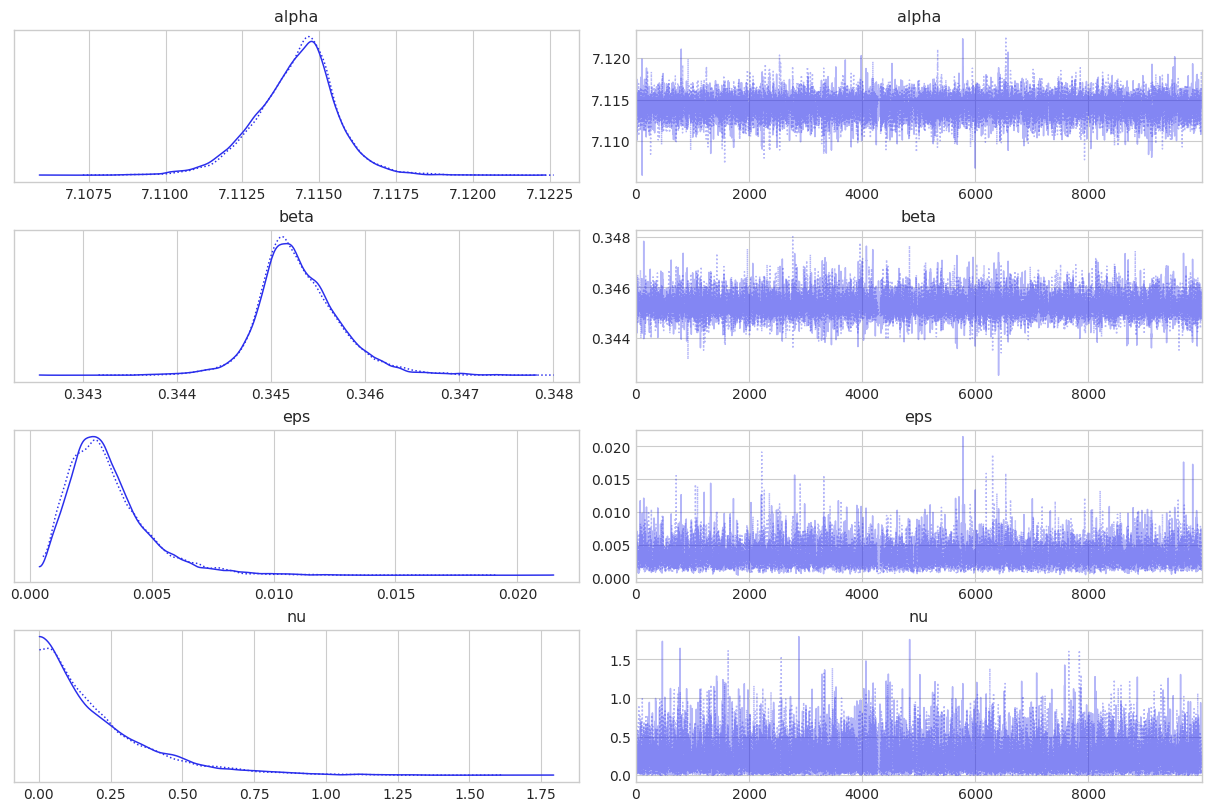

In [10]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps', 'nu'])
plt.show()

As we can see, the relevance of important outliers is strictly reduced.
In this case the posterior predictive distribution collapses to a single point.

In [11]:
# Compute average values of sampled parameters
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

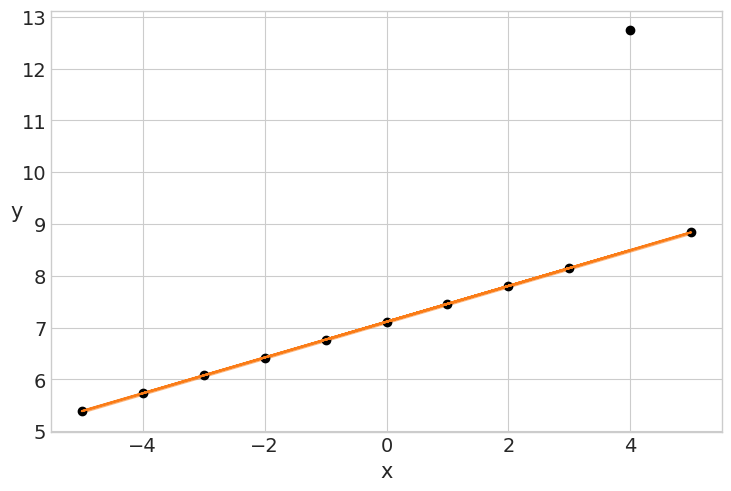

In [12]:
# Plot the HDI graph
az.plot_hdi(x, ppc['y_pred'])
plt.plot(x, y, 'o', c='k')
plt.plot(x, alpha_m + beta_m * x, c='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

# Generalized Linear Mdels

## Generalized Linear Models

A generalized linear model (GLM) is a flexible generalization of ordinary linear regression.
It generalizes linear regression by allowing the linear model to be related to the response variable via an **inverse link function** $f$.

$$\mu = f(\alpha + X\beta)$$

There are many inverse link function that can be used,
the simplest one is the _identity function_.
Others inverse link functions can be used to deal with _categorical variables_ or to _restrict the output_ to an interval (e.g. only positive).

## Logistic Regression

The **logistic regression** model is a generalization of the linear regression model, and thus its name.
We achieve this generalization by placing the _logistic function_ as an inverse link function.

$$\sigma(z) = \frac{1}{1+\exp(-z)}$$

where $\sigma: \mathbb{R} \to (0,1)$ denotes the logistic function.

The **logistic regression** model can be then formalized as follows.

$$\theta = \sigma(\alpha + X\beta)$$

$$Y \sim \mathrm{Bernoulli}(\theta)$$

[]

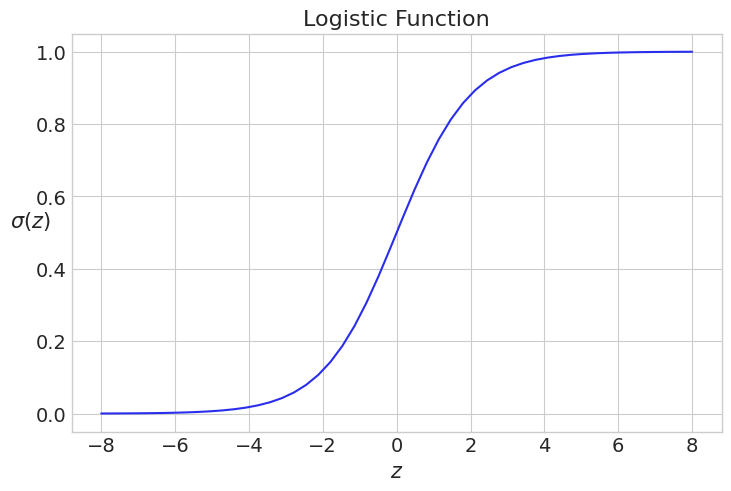

In [13]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('$z$')
plt.ylabel('$\sigma(z)$', rotation=0)
plt.title('Logistic Function'); plt.plot()

### Example

We will take in account a simple classification task with the IRIS dataset:
- 50 individual samples for each species
- 4 variable for each sample
- 3 classes

In [14]:
# Load the IRIS dataset
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


[]

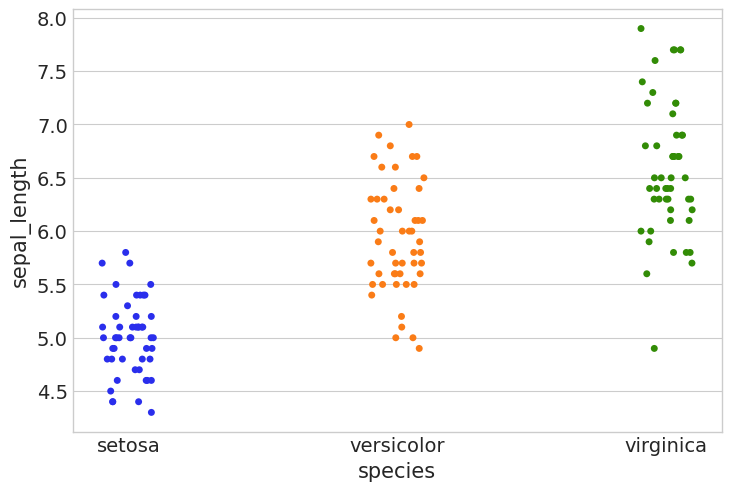

In [15]:
# The jitter has no meaning, is only for better visualization
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True); plt.plot()

[]

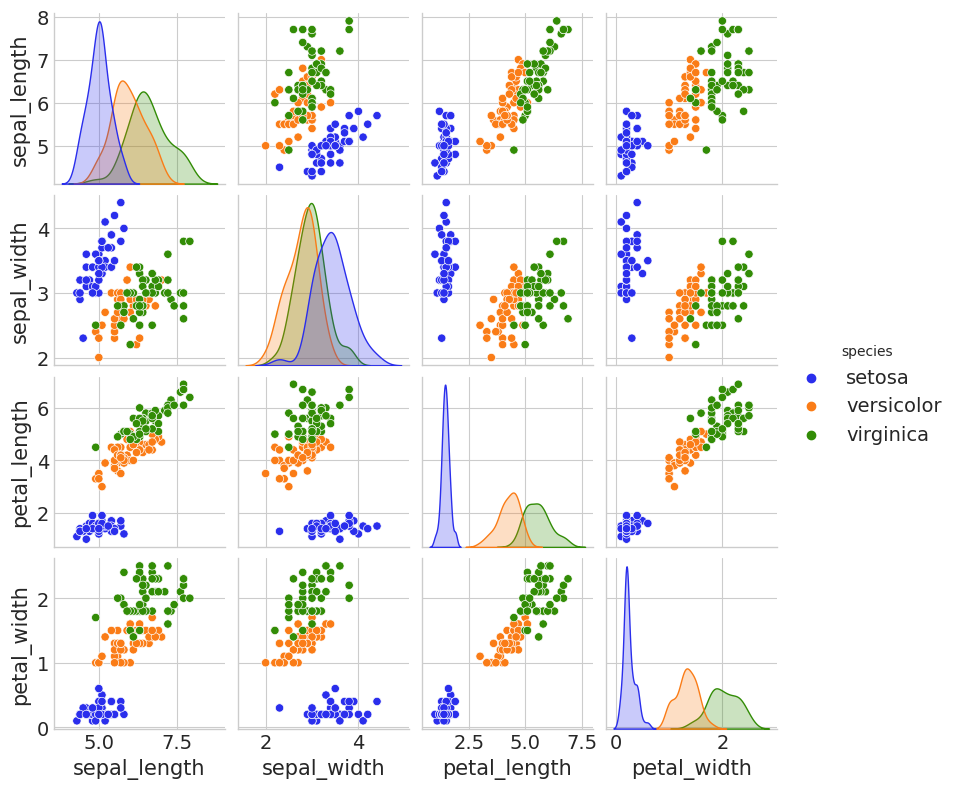

In [16]:
# Plot the pair-plot
sns.pairplot(iris, hue='species', diag_kind='kde', height=2); plt.plot()

We are now interested in a binary classification task:
- Two classes: `setosa` and `versicolor`;
- Just one independent variable (or feature): `sepal_lenght`

In [17]:
# Setup the binary IRIS dataset
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x = df[x_n].values
x_c = x - x.mean()

Centering the data can help in the process of sampling from the posterior.

In [18]:
# Build a PyMC3 logistic regression model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0, sd=10.0)
    beta = pm.Normal('beta', mu=0, sd=5.0)
    
    # Likelihood
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))  # Output of the logistic regression
    bd = pm.Deterministic('bd', -alpha / beta)  # Boundary decision (unused deterministic variable)
    yl = pm.Bernoulli('yl', p=theta, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 11 seconds.


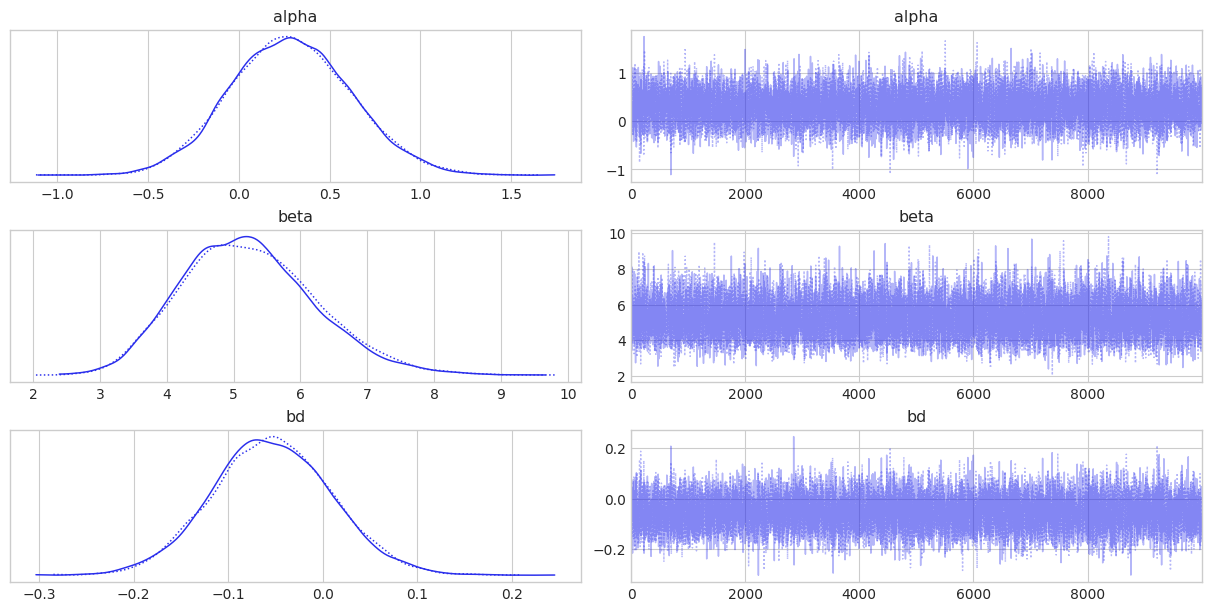

In [19]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'bd'])
plt.show()

[]

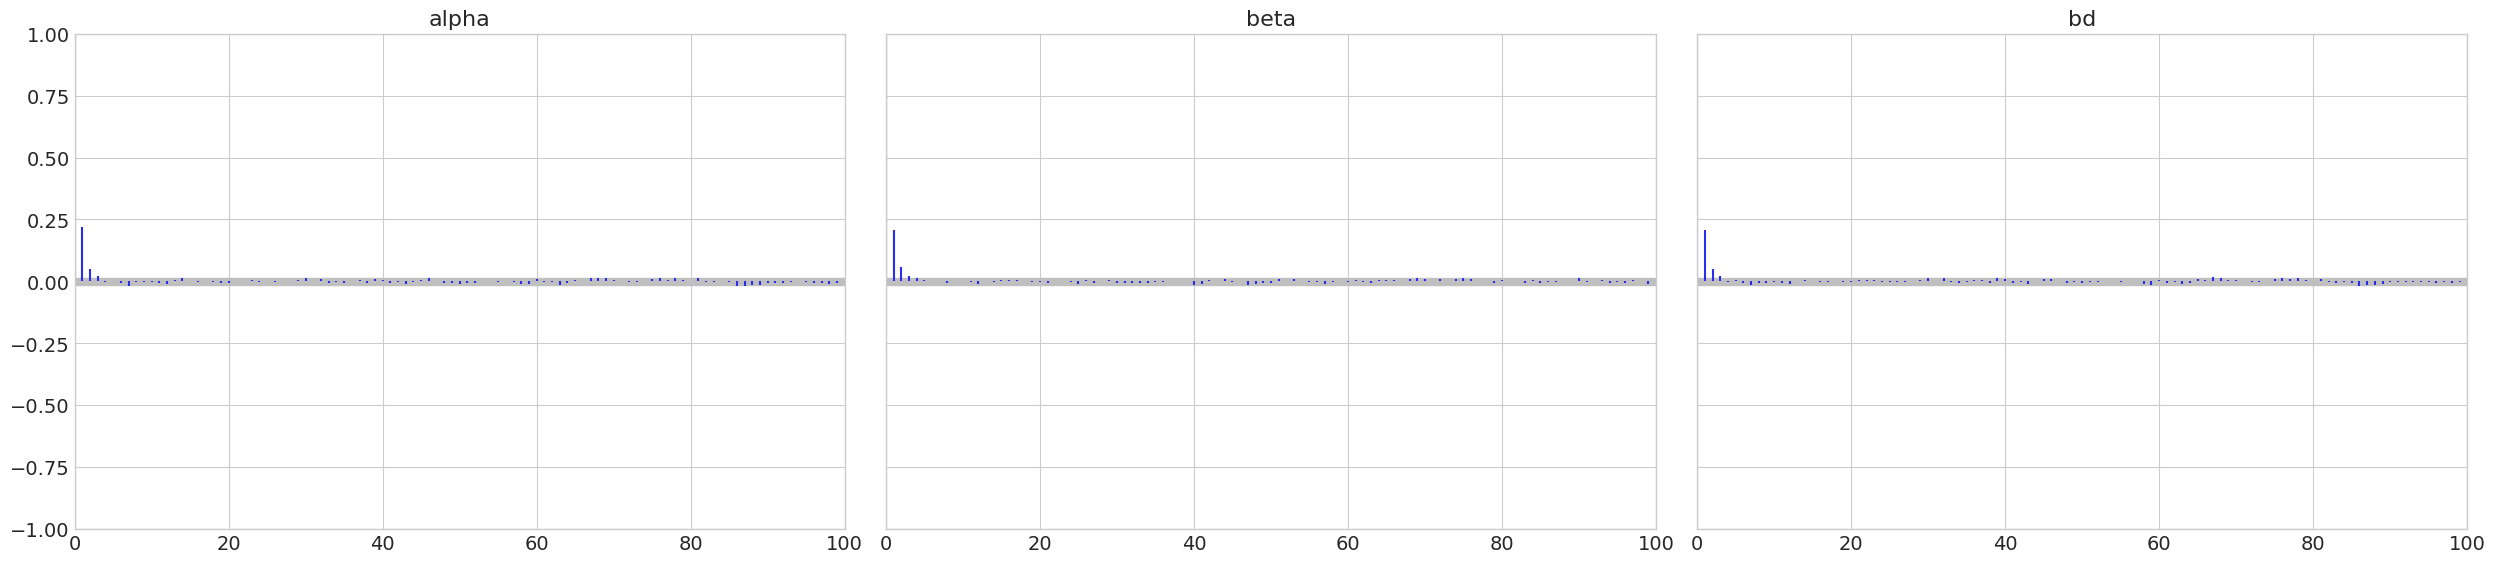

In [20]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'bd'], combined=True)
plt.plot()

In [21]:
def plot_logistic_decision_boundary(trace):
    posterior = trace['posterior']
    theta = posterior['theta']
    bd = posterior['bd']
    
    plt.scatter(x_c, np.random.normal(y, 0.02), marker='.', color=[f'C{c}' for c in y])
    az.plot_hdi(x_c, theta, color='C2')
    idx = np.argsort(x_c)
    avg_theta = np.mean(np.asarray(theta).reshape(-1, len(x_c)), axis=0)
    plt.plot(x_c[idx], avg_theta[idx], color='C2', lw=2)
    
    bd_hdi = az.hdi(bd)
    plt.fill_betweenx([0, 1], bd_hdi['bd'][0], bd_hdi['bd'][1], color='k', alpha=0.5)
    plt.vlines(bd.mean(), 0, 1, color='k')

    # Use original scale for xticks
    locs, _ = plt.xticks(); plt.xticks(locs, np.round(locs + x.mean(), 1))
    
    plt.xlabel(x_n)
    plt.ylabel('$\\theta$', rotation=0)
    plt.show()

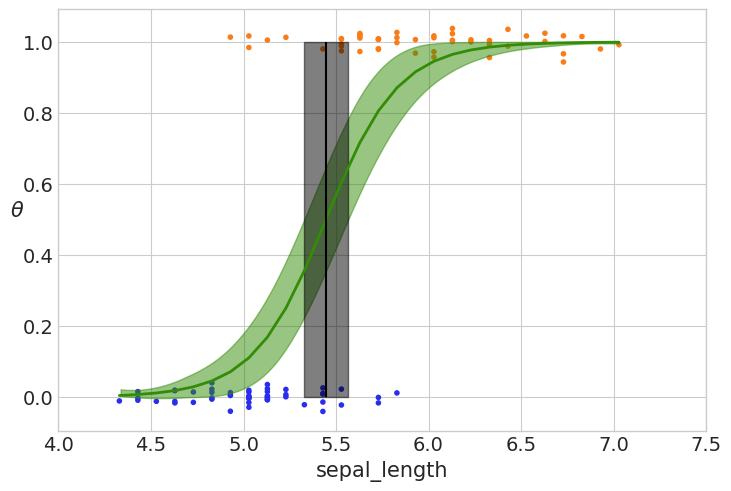

In [22]:
# Plot the decision boundary
plot_logistic_decision_boundary(trace)

The green line can be interpreted as the probability distribution of a flower being `versicolor` based on its `sepal_length`.

The boundary decision is represented as a (black) vertical line with a semi-transparent band for its 94% High Density Interval (HDI).

Note that the centroid of the boundary decision is the $X$ point where $Y=0.5$.

## Multivariate Linear and Logistic Regression

We can extend the **linear regression** model for multivariate data with $d$ features as follows.

$$\mu = \alpha + X^T\beta = \alpha + \sum_{i=1}^d \beta_iX_i$$

$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

where $X$ denotes the input features and Y denotes the target feature.
Note that we have different _slope_ parameters for each dimension.

Generally, linear regression enable a straightforward interpretation of parameters.
Each _slope_ parameter $\beta_i$ can be interpreted as the quantity to addition (or subtract) to the target variable $Y$, with a unit change of the $i$-th feature $X_i$.

Similarly, we can also extend the **logistic regression** model for multivariate data with $d$ features as follows.

$$\theta = \sigma(\alpha + X^T\beta)$$

$$Y \sim \mathrm{Bernoulli}(\theta)$$

### Example

In [23]:
# Setup the multivariate IRIS dataset for logistic regression
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x = df[x_n].values
x_c = x - x.mean(axis=0)

In [24]:
# Build a PyMC3 multivariate logistic regression model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0, sd=10.0)
    beta = pm.Normal('beta', mu=0, sd=5.0, shape=len(x_n))

    # Likelihood
    mu = alpha + pm.math.dot(x_c, beta)
    theta = pm.Deterministic('θ', tt.nnet.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha / beta[1] - beta[0] / beta[1] * x_c[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=20_000, tune=30_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 30_000 tune and 20_000 draw iterations (60_000 + 40_000 draws total) took 38 seconds.


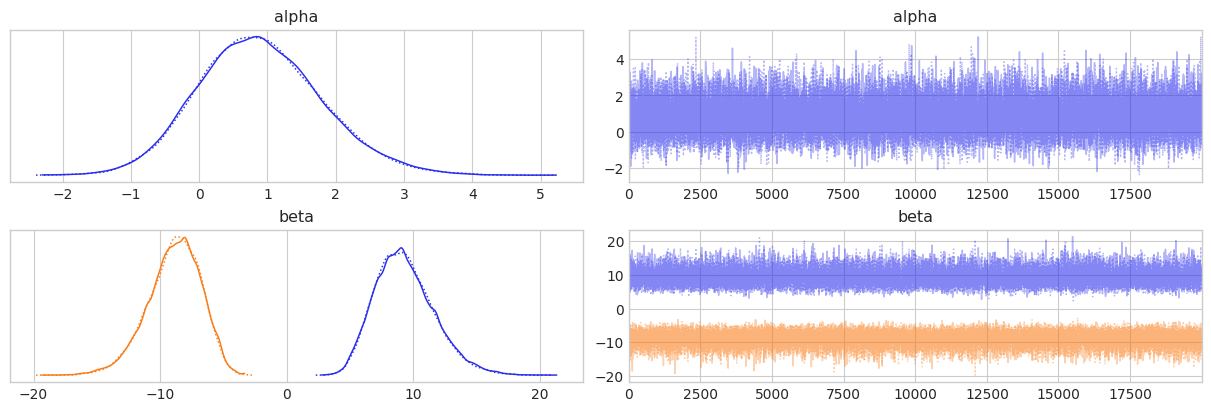

In [25]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta'])
plt.show()

[]

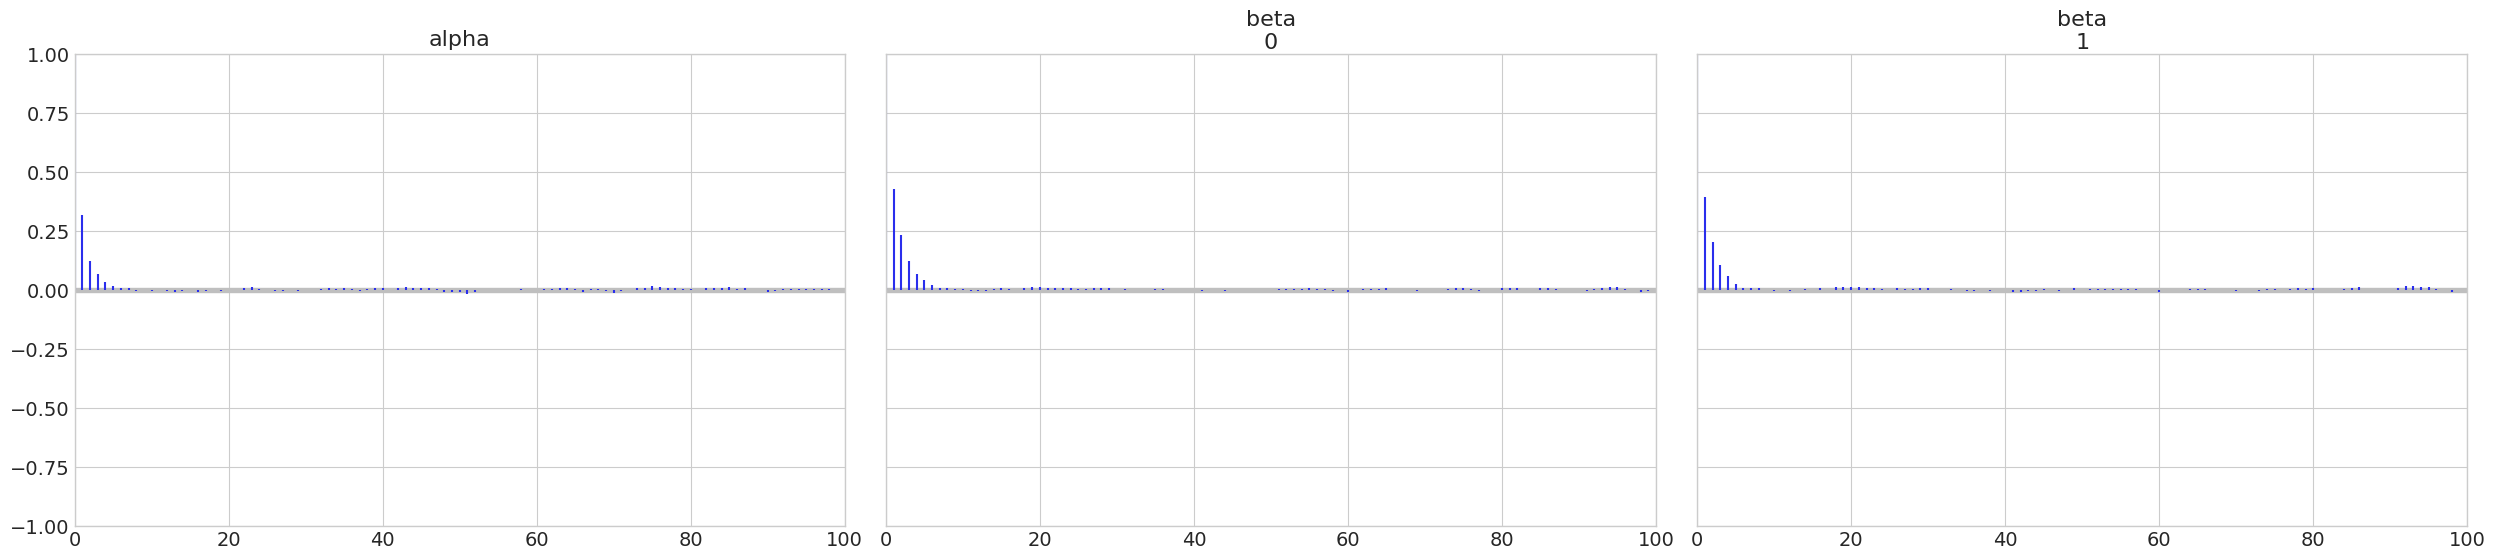

In [26]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta'], combined=True)
plt.plot()

In [27]:
def plot_logistic_decision_boundary_2d(trace):
    posterior = trace['posterior']
    bd = posterior['bd']

    idx = np.argsort(x_c[:, 0])
    avg_bd = np.mean(np.asarray(bd).reshape(-1, len(x_c)), axis=0)
    plt.scatter(x_c[:, 0], x_c[: ,1], c=[f'C{c}' for c in y])
    
    az.plot_hdi(x_c[:, 0], bd, color='k')
    plt.plot(x_c[:, 0][idx], avg_bd[idx], color='k')

    # Use original scale for xticks and yticks
    locs, _ = plt.xticks(); plt.xticks(locs, np.round(locs + x.mean(axis=0)[0], 1))
    locs, _ = plt.yticks(); plt.yticks(locs, np.round(locs + x.mean(axis=0)[1], 1))
    
    plt.xlabel(x_n[0])
    plt.ylabel(x_n[1])
    plt.show()

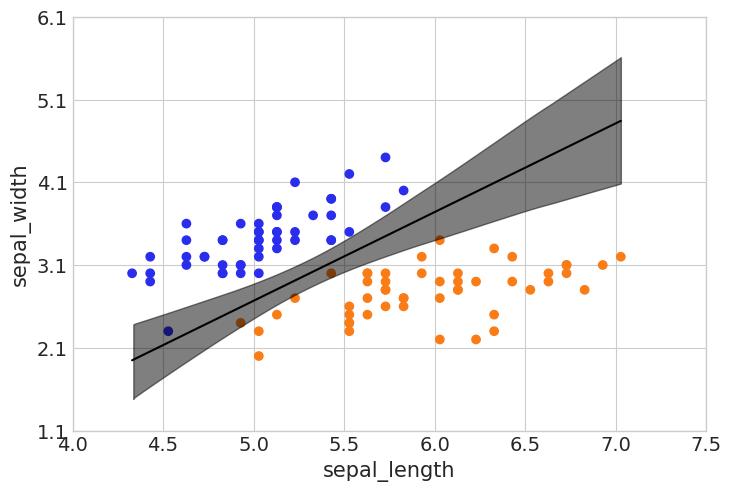

In [28]:
# Plot the decision boundary
plot_logistic_decision_boundary_2d(trace)

# Poisson Regression

## Poisson Regression

Another very popular generalized linear model is the **Poisson regression**. This model assumes data is distributed according to the Poisson distribution.

One scenario where Poisson distribution is useful is when _counting_ things, such as:
- the decay of a radioactive nucleus;
- the number of children per couple, or the number of Twitter followers;
- models using discrete non-negative integers

The probability mass function (PMF) of the Poisson distribution is defined as follows.

$$f(k;\ \theta) = \frac{\theta^k e^{-\theta}}{k!}$$

where $\theta$ is the average number of eventt per unit of time (or space), and $k$ is a non-negative integer. Note that both expectation and variance of a Poisson distribution coincide with $\theta$.

## Zero-Inflated Poisson model

Often when performing posterior predictive check, model generates fewer 0s compared to the data.
Howe do we model such case ?

We assume we have a mixture of two processes modeled by:
- Poisson distribution with probability $\psi$;
- _extra zeros_ with probability $1 - \psi$.

The **Zero-Inflated Poisson (ZIP)** model can formalized as follows.

$$P(Y = 0) = 1 - \psi + \psi e^{-\theta}$$
$$P(Y = x_i) = \psi\frac{\mu^{x_i} e^{-\theta}}{x_i!}$$

We use the exponential function as inverse-link function to ensure positive numbers, i.e. $\theta = e^{\alpha + X\beta}$.

### Example

The fish dataset has the following characteristics:
- 250 group of visitors at park
    - number of fish they caught (`count`);
    - children per group (`child`);
    - brought a camper or not (`camper`).

We are going to build a model that predicts the number of fish caught.

In [29]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [30]:
# Build a PyMC3 ZIP regression model
with pm.Model() as model:
    # Prior distributions
    psi = pm.Beta('psi', 1.0, 1.0)
    alpha = pm.Normal('alpha', mu=0.0, sd=10.0)
    beta = pm.Normal('beta', 0.0, 10.0, shape=2)

    # Likelihood
    theta = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', psi, theta, observed=fish_data['count'])

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=20_000, tune=30_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]


Sampling 2 chains for 30_000 tune and 20_000 draw iterations (60_000 + 40_000 draws total) took 83 seconds.


In [31]:
def plot_fish_distributions(trace):
    posterior = trace['posterior']
    alpha = np.asarray(posterior['alpha']).reshape(-1)
    beta = np.asarray(posterior['beta']).reshape(-1, 2)
    idx = np.random.choice(len(alpha), 1024, replace=False)
    alpha = alpha[idx]
    beta = beta[idx]
    children = [0, 1, 2, 3, 4]
    fish_count_pred_0 = []
    fish_count_pred_1 = []
    for n in children:
        without_camper = alpha + beta[:, 0] * n
        with_camper = without_camper + beta[:, 1]
        fish_count_pred_0.append(np.exp(without_camper))
        fish_count_pred_1.append(np.exp(with_camper))
    plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
    plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

    plt.xticks(children);
    plt.xlabel('Number of Children')
    plt.ylabel('Fish Caught')
    plt.plot([], 'C0o', label='Without Camper')
    plt.plot([], 'C1o', label='With Camper')
    plt.legend()
    plt.show()  

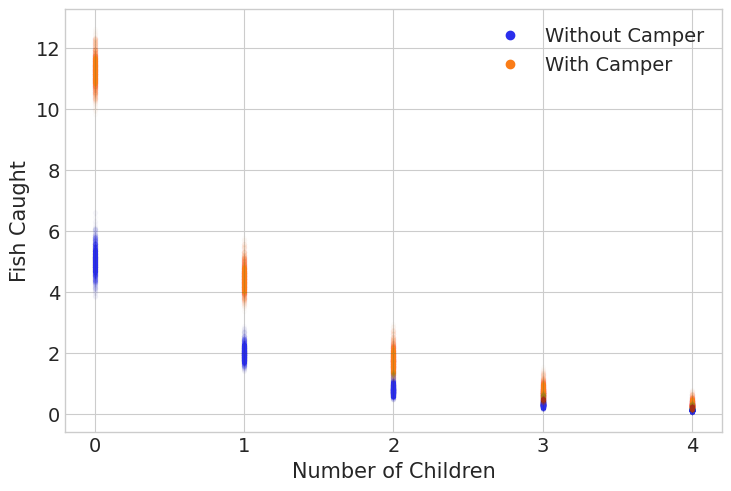

In [32]:
# Plot the distributions of fish caught with and without camper
# and with varying the number of children
plot_fish_distributions(trace)

We can highlight the following points.
- Expected number of fish caught decreases as number of children increases;
- Having a camper increases the expected count of fish.